### 📚 기본 순환 신경망 구현

#### 💡 라이브러리 및 데이터 불러오기

- 주가 데이터를 이용해 실습
- 데이터 : 일자, 시작가, 고가, 저가, 종가, 보정된 종가, 거래량으로 구성된 csv 파일
- `pandas`를 이용해 csv 파일을 데이터프레임 형태로 불러온다.
    - 데이터는 보정된 종가를 제외한 나머지를 사용
    - 일자를 제외하고 MinMax 스케일을 사용하여 데이터 가공

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("./data/kospi.csv")
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


-----------------------------------------------------------------------------------------------------

#### 💡 텐서 데이터 만들기

- 사용할 데이터
    - 인스턴스 : 431개
    - 피쳐 : 4개(Open, High, Low, Volume)
    - 타깃값 : 종가(Close)
    - 즉, 431x4 시계열 데이터를 가지고 있다.
- 이 단계에서 고려해야 할 점은 
    - **며칠을 사용하여 다음 날 종가를 예측**하느냐는 것
    - 학습 데이터와 평가 데이터의 비율

📌 데이터 프레임에서는 `values`를 사용하여 넘파이 배열로 만들 수 있다. (입력 데이터와 타깃 데이터 생성)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X = df[['Open', 'High', 'Low', 'Volume']].values # (431, 4)
y = df['Close'].values # (431, )

📌 시퀀스 데이터를 만드는 함수 생성

In [34]:
def seq_data(x, y, sequence_length) :
    
    # x, y값에 대한 시퀀스를 저장하는 빈 리스트 생성
    x_seq =[]
    y_seq = []
    
    for i in range(len(x) - sequence_length) :
        x_seq.append(x[i : i+sequence_length])
        y_seq.append(y[i+sequence_length])
        
    # GPU용 텐서로 변환    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

- 미리 정한 시퀀스의 길이로 쪼개어 저장한다.
    - 이때 데이터는 for문의 1회 당 한 칸 움직여 저장한다. (보폭 정해줄 수도 있음)
        - 예를 들어, 길이가 3이면 처음 저장된 데이터는 0, 1, 2번째 데이터가 한 묶음 -> 1, 2, 3 -> 2, 3, 4 -> ...
    - y 데이터는 다음 날 값이 타깃값이기 때문에 입력값이 x[i : i+sequence_length]이면 타깃값은 y[i+sequence_length]
        - 예를 들어, X가 0, 1, 2번째 데이터로 묶일 때 3번째 데이터의 y값이 대응되는 타깃값

- GPU용 텐서로 변환 후, y 데이터를 `view(-1, 1)`를 사용하여 2차원으로 바꿔준다.
    - 그 이유는 **MSE Loss가 기본적으로 2차원 타깃 데이터를 받기** 때문

In [35]:
split = 200
sequence_length = 5
x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


- 시퀀스의 길이를 5로 한다면 426개 [431(전체 데이터) - 5(시퀀스 길이)]의 시퀀스 데이터를 만들 수 있다.
- 200개의 데이터는 학습 데이터로 사용하고, 이후 데이터는 평가 데이터로 사용

In [41]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

In [43]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size, shuffle=False)

-----------------------------------------------------------------------------------------------------

#### 💡 RNN 구축에 필요한 하이퍼 파라미터 정의하기

In [47]:
# x_seq.size() : (426, 5, 4)
# 입력 변수의 개수
input_size = x_seq.size(2)
# 은닉층의 개수
num_layers = 2
# 은닉 상태를 저장하는 벡터의 크기
hidden_size = 8

-----------------------------------------------------------------------------------------------------

#### 💡 RNN 구축하기

In [48]:
class VanillaRNN(nn.Module) :
    def __init__(self, input_size, num_layers, hidden_size, sequence_length, device) :
        super(VanillaRNN, self).__init__()
        # 각 변수 정의
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1),
                                nn.Sigmoid())
        
    def forward(self, x) :
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

- `변수 정의`
    - input_size : 입력값의 크기(이미지의 열 크기)
    - hidden_size : 은닉층의 노드수
    - num_layers : 은닉층의 개수
    - seq_length : 시계열의 길이(이미지의 행 크기)
    - num_classes : 클래스 수
    - device : gpu 활용 여부
    
- `self.rnn`
    - nn.RNN을 이용하면 한 줄로 모델이 정의된다.
    - 주의할 점은 원래 nn.RNN의 입력 데이터의 크기는 **시퀀스의 길이 x 배치 사이즈 x 변수의 크기**이기 때문에 (200, 5, 4)크기의 데이터를 (5, 200, 4)로 변경해야 한다.
    - 하지만 batch_first = True로 적용하면 기존의 200x5x4 데이터를 그대로 사용할 수 있다. 
    
    
- `self.fc`
    - RNN에서 나온 출력값을 FC층 하나를 거쳐 **하나의 예측값**을 뽑을 수 있도록 self.fc를 정의
    
- `h0`
    - RNN은 이전h를 받아 계산하기 때문에 첫번째 계산 시에는 이전 h가 없기 때문에 초깃값을 영텐서로 정의하여 h0를 대입한다. 
- `out, _`
    - 정의된 self.rnn 이용
    - many to mant 방법을 가지고 각 시간에 대한 **예측값**과 **은닉 상태**를 산출한다.
    - 이 예시에서는 은닉 상태를 사용하지 않기 때문에 _로 처리하여 함수와 반환값을 받지 않는다. 
- `out`
    - 모든 출력값을 사용하기 위해 out을 일렬로 만들어 self.fc에 넣는다. 

-----------------------------------------------------------------------------------------------------

#### 💡 RNN 모델 불러오기

- 입력값의 크기, 은닉 상태 크기, 시퀀스 길이, 은닉층 개수(레이어 수), gpu 연산을 위한 device 변수까지 모델에 넣어준다.
- 또한 GPU 연산을 위해 model 뒤에 `.to(device)`

In [49]:
model = VanillaRNN(input_size = input_size, 
                   hidden_size = hidden_size,
                   sequence_length = sequence_length,
                   num_layers = num_layers,
                   device = device).to(device)

-----------------------------------------------------------------------------------------------------

#### 💡 손실 함수 및 최적화 방법 정의

- 주가를 예측하는 것 : 회귀 문제
- 대표적인 MSE 손실 함수를 사용
- 학습은 301회
- 최적화 방법 : Adam

In [50]:
criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=1e-3)

-----------------------------------------------------------------------------------------------------

#### 💡 모델 학습하기

- 학습 과정은 전형적인 지도 학습 방법

In [52]:
loss_graph = []
n = len(train_loader) # 200/20

for epoch in range(num_epochs) :
    running_loss = 0.0
    
    for data in train_loader :
        # 배치 데이터
        seq, target = data 
        
        # 출력값 산출
        out = model(seq)
        
        # 손실함수 계산
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # 최적화
        running_loss += loss.item()
        
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0 :
        print('[epoch : %d] loss : %.4f' %(epoch, running_loss/n))

[epoch : 0] loss : 0.0273
[epoch : 100] loss : 0.0008
[epoch : 200] loss : 0.0006
[epoch : 300] loss : 0.0004


-----------------------------------------------------------------------------------------------------

#### 💡 학습 손실 함수값 그리기

- 손실 함수를 통해 단편적으로 훈련이 잘 됐음을 확인할 수 있다. 

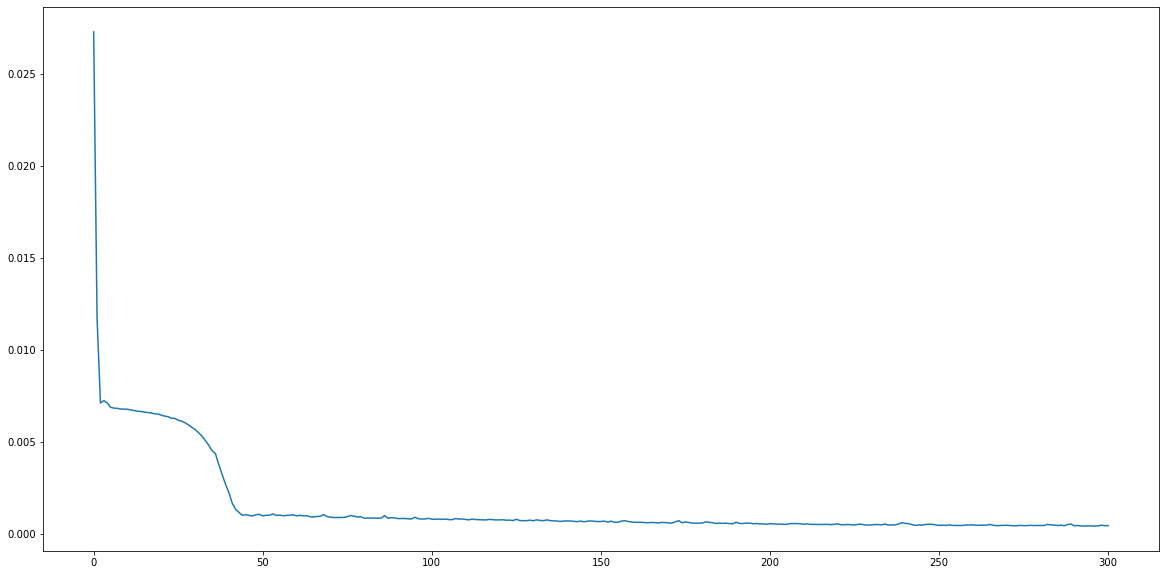

In [53]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

-----------------------------------------------------------------------------------------------------

#### 💡 주가 그리기

- `ConcatDataset` 
    - 여러 개의 데이터 세트를 함께 사용할 수 있도록 도와준다.
    - 입력값은 데이터 세트의 리스트를 받기 때문에 앞서 정의한 train, test를 리스트 [train, test]로 넣어준다. 
- `pred`
    - 예측값을 저장할 빈 텐서
    - 예측값은 GPU 텐서이다. 따라서 CPU 텐서로 변환 후, `.tolist()`를 이용하여 리슽트로 만들어 순차적으로 리스트를 이어 붙인다.

In [61]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)
with torch.no_grad() :
    pred = []
    model.eval()
    for data in data_loader :
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

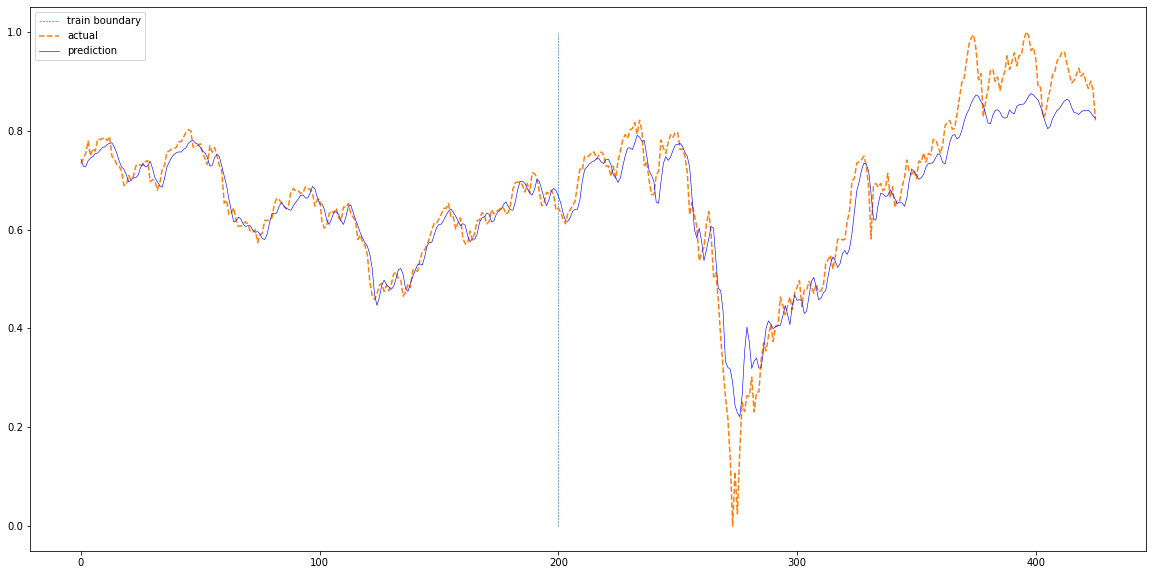

In [58]:
plt.figure(figsize=(20, 10))
# 학습 일수와 평가 일수를 구분짓는 선
plt.plot(np.ones(100)*len(train), np.linspace(0, 1, 100), '--', linewidth=0.6)
# 실제값과 예측값
plt.plot(df['Close'][sequence_length:].values, '--')
plt.plot(pred, 'b', linewidth = 0.6)

plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()

🔎 파란색 수직선을 기준으로 왼쪽을 훈련 데이터로 사용하고 오른쪽을 평가 데이터로 사용
- 훈련 데이터 부분은 학습이 잘 되어 실제값과 예측값이 잘 맞는다고 보인다.
- 평가 부분은 급락하는 부분을 잡아내지 못하고, 전체적으로 예측을 잘 하는 것처럼 보이지만 오른쪽으로 쉬프트된 현상을 볼 수 있다. 